In [20]:
#initialise

import extractor
fps, resolution = extractor.run('input_videos/input.mp4')






Taking input input_videos/input.mp4
FPS: 30.0
Resolution: 720x720
Audio extracted to output_data/audio.mp3
Extracted 661 frames.
Feature data has been collected!
Writing data to csv
Features saved to output_data/output_features.csv
Extraction completed!


In [21]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor  




In [22]:
# config:
unbiased = True # Should data be shuffled before training. Biased data is more accurate with reconstruction of the original video.
feature_threshold = 0.3 # between 0 and 1, how much should the data correlate to the target variable? 1 is 1 to 1 and 0 is not at all

In [23]:
import pydub

df = pd.read_csv('output_data/output_features.csv')
df['frame_index'] = df.index
df['normalized_index']=df['frame_index']/len(df)

audio_full = pydub.AudioSegment.from_mp3('output_data/audio.mp3')

slice_paths = []

for i in range(len(df['timestamp'])):
    frame_start = df['timestamp'][i]
    if i >= len(df['timestamp'])-1:
        frame_end = len(audio_full)
    else:
        frame_end = df['timestamp'][(i+1)]
    slice:pydub.AudioSegment = audio_full[frame_start:frame_end]
    slice_path = f'output_slices/audio_slice_{frame_start*0.001}_{i}.wav'
    slice.export(slice_path, format='wav')
    slice_paths.append(slice_path)

    




df['audio_slice_path'] = slice_paths
if unbiased:
    df = df.sample(frac=1.0,random_state=42).reset_index(drop=True)
print(df[['frame_filename','frame_index','normalized_index','audio_slice_path']].head())

                           frame_filename  frame_index  normalized_index  \
0  output_frames/frame_630_time_21000.jpg          630          0.953101   
1   output_frames/frame_271_time_9033.jpg          271          0.409985   
2   output_frames/frame_135_time_4500.jpg          135          0.204236   
3  output_frames/frame_483_time_16100.jpg          483          0.730711   
4    output_frames/frame_90_time_3000.jpg           90          0.136157   

                          audio_slice_path  
0   output_slices/audio_slice_21.0_630.wav  
1  output_slices/audio_slice_9.033_271.wav  
2    output_slices/audio_slice_4.5_135.wav  
3   output_slices/audio_slice_16.1_483.wav  
4     output_slices/audio_slice_3.0_90.wav  


In [24]:
# Check shape
print("DataFrame shape:", df.shape)

# Check first few rows
print(df.head())



# Check if you accidentally only have one row
if df.shape[0] <= 1:
    print("Warning: Only 1 row detected!")

#df = df[df != 0] # remove redundant parameters
# Check for missing rows or NaNs
df = df.loc[:,(df != 0).any(axis=0)]
print(df.isnull().sum())



DataFrame shape: (661, 1517)
   timestamp                          frame_filename  hist_bin_0  hist_bin_1  \
0      21000  output_frames/frame_630_time_21000.jpg    0.983379    0.164549   
1       9033   output_frames/frame_271_time_9033.jpg    0.946081    0.154325   
2       4500   output_frames/frame_135_time_4500.jpg    0.987594    0.141838   
3      16100  output_frames/frame_483_time_16100.jpg    0.926124    0.096257   
4       3000    output_frames/frame_90_time_3000.jpg    0.987030    0.148911   

   hist_bin_2  hist_bin_3  hist_bin_4  hist_bin_5  hist_bin_6  hist_bin_7  \
0    0.034573    0.000294    0.000000    0.000000    0.000000    0.000000   
1    0.058671    0.011779    0.000000    0.000000    0.000000    0.000000   
2    0.015405    0.009899    0.003457    0.000165    0.000017    0.000028   
3    0.001123    0.000026    0.000000    0.000000    0.000000    0.000000   
4    0.015144    0.009762    0.003365    0.000173    0.000011    0.000019   

   ...  edge_993  edge_994 

In [25]:
#Correlation test
numerical_df = df.select_dtypes(include=['float64','int64'])



corr_matrix = numerical_df.corr()
normalized_index_corr = corr_matrix['normalized_index'].sort_values(ascending=False)
normalized_index_corr = normalized_index_corr.drop(['normalized_index','timestamp','frame_index'])
print(normalized_index_corr)

hist_bin_145    0.360664
hist_bin_211    0.357253
hist_bin_501    0.348983
hist_bin_291    0.346357
hist_bin_218    0.331281
                  ...   
hist_bin_78    -0.493177
hist_bin_150   -0.661907
hist_bin_143   -0.683861
hist_bin_142   -0.698862
hist_bin_141   -0.701348
Name: normalized_index, Length: 422, dtype: float64


In [26]:

X = df.drop(['timestamp','frame_filename','frame_index','normalized_index','audio_slice_path'], axis=1)
y = df['normalized_index']

In [27]:
# get strong features
strong_features = normalized_index_corr[abs(normalized_index_corr) > feature_threshold].index.to_list()
print(strong_features)
X = X[strong_features]

['hist_bin_145', 'hist_bin_211', 'hist_bin_501', 'hist_bin_291', 'hist_bin_218', 'hist_bin_289', 'hist_bin_500', 'hist_bin_146', 'hist_bin_364', 'hist_bin_73', 'hist_bin_217', 'hist_bin_428', 'hist_bin_347', 'hist_bin_290', 'hist_bin_355', 'hist_bin_274', 'hist_bin_429', 'hist_bin_275', 'hist_bin_77', 'hist_bin_78', 'hist_bin_150', 'hist_bin_143', 'hist_bin_142', 'hist_bin_141']


In [28]:
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

model.fit(X_train, y_train)


RandomForestRegressor(n_jobs=-1, random_state=42)

In [29]:
y_pred = model.predict(X_test)

In [30]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")

MSE: 0.0069
R2 Score: 0.9171


In [31]:
df['predicted_normalized_index'] = model.predict(X)

# sort by predicted order
df_sorted = df.sort_values(by='predicted_normalized_index')

print(df_sorted[['frame_filename','predicted_normalized_index']].head(10))


                          frame_filename  predicted_normalized_index
61     output_frames/frame_2_time_66.jpg                    0.012224
38   output_frames/frame_10_time_333.jpg                    0.018396
180  output_frames/frame_11_time_366.jpg                    0.018684
411   output_frames/frame_8_time_266.jpg                    0.018926
342   output_frames/frame_5_time_166.jpg                    0.020000
304  output_frames/frame_12_time_400.jpg                    0.020182
614  output_frames/frame_13_time_433.jpg                    0.020469
90    output_frames/frame_6_time_200.jpg                    0.020893
576  output_frames/frame_14_time_466.jpg                    0.021271
209   output_frames/frame_9_time_300.jpg                    0.022148


In [32]:
import cv2

output_video = cv2.VideoWriter('output_data/reconstructed.avi',
                               cv2.VideoWriter_fourcc(*'XVID'),
                               fps,
                               resolution)  


for _, row in df_sorted.iterrows():
    frame = cv2.imread(row['frame_filename'])
    output_video.write(frame)

output_video.release()
print("Reconstructed Video Saved!!")

Reconstructed Video Saved!!


In [33]:
final_audio:pydub.AudioSegment = pydub.AudioSegment.empty()
for s in df_sorted['audio_slice_path']:
    sorted_slice = pydub.AudioSegment.from_wav(s)
    final_audio = final_audio.append(sorted_slice, crossfade=0)
final_audio.export('output_data/final_audio.mp3')

<_io.BufferedRandom name='output_data/final_audio.mp3'>

In [34]:
import subprocess

def combine_audio_video(reconstructed_video, audio_file, output_video):
    command = ['ffmpeg', '-i', reconstructed_video, '-i', audio_file, '-c:v', 'copy', '-c:a', 'aac', output_video, '-y']
    subprocess.run(command, check=True)
    print(f"Final video saved to {output_video}")

combine_audio_video('output_data/reconstructed.avi', 'output_data/final_audio.mp3','output_data/final_output.mp4')

Final video saved to output_data/final_output.mp4


In [35]:
print(df_sorted['audio_slice_path'])
df.to_csv('output_data/final_output_data.csv')


61                 output_slices/audio_slice_0.066_2.wav
38                output_slices/audio_slice_0.333_10.wav
180               output_slices/audio_slice_0.366_11.wav
411                output_slices/audio_slice_0.266_8.wav
342                output_slices/audio_slice_0.166_5.wav
                             ...                        
257    output_slices/audio_slice_21.766000000000002_6...
86     output_slices/audio_slice_21.900000000000002_6...
36              output_slices/audio_slice_21.866_656.wav
373             output_slices/audio_slice_21.966_659.wav
589             output_slices/audio_slice_21.933_658.wav
Name: audio_slice_path, Length: 661, dtype: object


In [36]:
from joblib import dump
dump(model, 'model/video_reconstructor_model.joblib')

used_columns = X.columns.tolist()

# prevent misalignment of columns for other video inputs
import json
with open('output_data/used_feature_columns.json', 'w') as f:
    json.dump(used_columns, f)

['hist_bin_145', 'hist_bin_211', 'hist_bin_501', 'hist_bin_291', 'hist_bin_218', 'hist_bin_289', 'hist_bin_500', 'hist_bin_146', 'hist_bin_364', 'hist_bin_73', 'hist_bin_217', 'hist_bin_428', 'hist_bin_347', 'hist_bin_290', 'hist_bin_355', 'hist_bin_274', 'hist_bin_429', 'hist_bin_275', 'hist_bin_77', 'hist_bin_78', 'hist_bin_150', 'hist_bin_143', 'hist_bin_142', 'hist_bin_141']


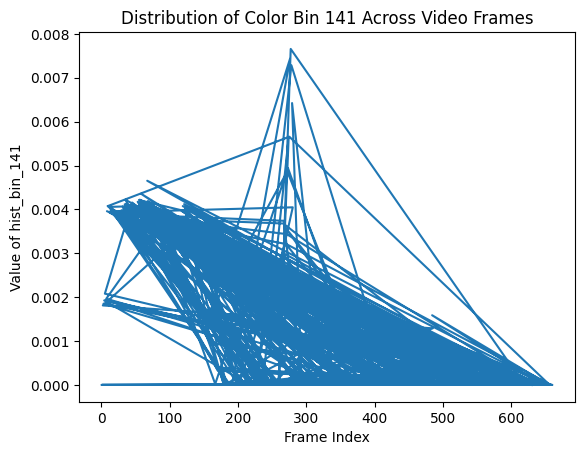

In [37]:
# debug

print(X.columns.to_list())

import matplotlib.pyplot as plt
plt.plot(df['frame_index'], df['hist_bin_141'])
plt.xlabel('Frame Index')
plt.ylabel('Value of hist_bin_141')
plt.title('Distribution of Color Bin 141 Across Video Frames')
plt.show()

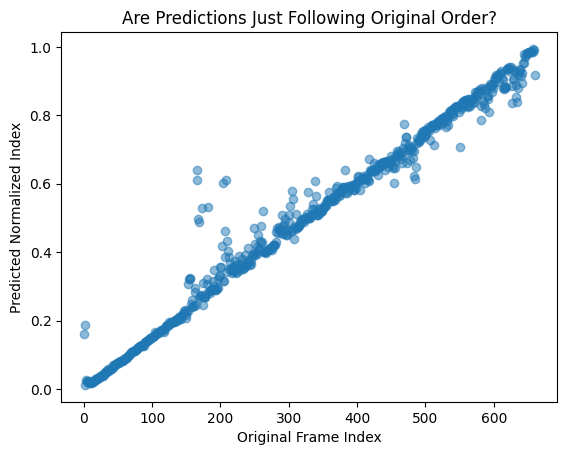

In [38]:
plt.scatter(df['frame_index'], df['predicted_normalized_index'], alpha=0.5)
plt.xlabel("Original Frame Index")
plt.ylabel("Predicted Normalized Index")
plt.title("Are Predictions Just Following Original Order?")
plt.show()
